In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from scipy import stats

In [2]:
def bar_chart(notes, freq, set_X):
    N = len(set_X)
    ind = np.arange(N) # the x locations for the groups

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])


    ax.bar(ind, freq, 0.75)

    ax.set_ylabel('Freq')
    ax.set_xlabel('Notes')
    ax.set_title('Frequency by note for a voice')
    plt.xticks(ind, set_X)
    steps = 100
    ax.set_yticks(np.arange(0, max(freq)+steps, steps))
    plt.show()

In [3]:
dat = pd.read_csv("F.txt", sep="\t", header=None)
dat

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
3819,0,0,49,0
3820,0,0,51,0
3821,0,0,51,0
3822,0,0,54,0


In [4]:
X = list(dat[3]) # 4th voice
print(X[:10])
set_X = list(set(X))
print(len(set_X), set_X)

[0, 0, 0, 0, 0, 0, 0, 0, 42, 42]
26 [0, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


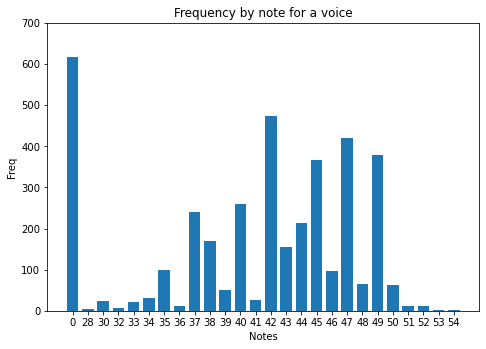

In [5]:
# frequency per note in the voice
notes = []
freq = []
for x in set_X:
    notes.append(str(x))
    freq.append(X.count(x))
#     print(f"{x}:\t{X.count(x)}/{len(X)} ~\t{round((X.count(x)/len(X))*100,2)} %")

bar_chart(notes, freq, set_X)

In [6]:
# get range, mode, mean, probabilities per range for each note in the voice
len_dict = {}
c = 0

for idx, x in enumerate(X):
    if x not in len_dict.keys():
        len_dict[x] = []
    if idx == 0:
        c += 1
    elif x == X[idx-1]:
        c += 1
    else:
        len_dict[X[idx-1]].append(c)
        c = 1
        
for k,v in len_dict.items():
    num = round(np.mean(v))
    if num % 2 != 0:
        num += 1
    d = {}
    for i in v:
        d[i] = round(v.count(i)/len(v), 2)
    len_dict[k] = {"range": v, "mode": stats.mode(v)[0][0], "mean": num, "pd": d}

# example note: 0
print(len_dict[0])

{'range': [8, 48, 4, 16, 48, 208, 4, 4, 4, 4, 4, 14, 4, 4, 4, 16, 4, 4, 160, 4, 4, 4, 4, 4, 4, 20], 'mode': 4, 'mean': 24, 'pd': {8: 0.04, 48: 0.08, 4: 0.65, 16: 0.08, 208: 0.04, 14: 0.04, 160: 0.04, 20: 0.04}}


In [7]:
# show range of notes
len_idx_dict = {}
c = 0

for idx, x in enumerate(X):
    if idx == 0:
        c += 1
    elif x == X[idx-1]:
        c += 1
    else:
        len_idx_dict[f"{X[idx-1]}_{idx-1}"] = c
        c = 1
        
len_list = [v for k,v in len_idx_dict.items()]
print(set(len_list))
len_idx_dict

{32, 1, 2, 160, 4, 6, 8, 10, 12, 14, 16, 48, 208, 18, 20, 22}


{'0_7': 8,
 '42_15': 8,
 '49_27': 12,
 '47_31': 4,
 '45_47': 16,
 '47_63': 16,
 '49_79': 16,
 '42_87': 8,
 '45_99': 12,
 '39_103': 4,
 '44_111': 8,
 '37_115': 4,
 '44_119': 4,
 '49_123': 4,
 '47_127': 4,
 '45_131': 4,
 '42_135': 4,
 '50_139': 4,
 '49_143': 4,
 '47_147': 4,
 '44_151': 4,
 '41_155': 4,
 '42_157': 2,
 '44_159': 2,
 '45_163': 4,
 '42_167': 4,
 '40_171': 4,
 '38_175': 4,
 '37_179': 4,
 '35_183': 4,
 '37_191': 8,
 '30_203': 12,
 '42_207': 4,
 '44_219': 12,
 '42_221': 2,
 '44_223': 2,
 '45_231': 8,
 '46_239': 8,
 '47_251': 12,
 '46_253': 2,
 '44_255': 2,
 '46_263': 8,
 '48_271': 8,
 '49_279': 8,
 '0_327': 48,
 '42_335': 8,
 '37_347': 12,
 '39_351': 4,
 '40_367': 16,
 '38_383': 16,
 '37_399': 16,
 '42_415': 16,
 '40_419': 4,
 '42_423': 4,
 '43_435': 12,
 '37_439': 4,
 '42_443': 4,
 '40_447': 4,
 '39_455': 8,
 '38_471': 16,
 '37_479': 8,
 '35_487': 8,
 '0_491': 4,
 '35_495': 4,
 '42_507': 12,
 '44_509': 2,
 '45_511': 2,
 '47_523': 12,
 '46_525': 2,
 '44_527': 2,
 '46_531': 4,
 

In [8]:
# convert series of notes of length n to 1
X_one = []

for idx, x in enumerate(X):
    if idx == 0:
        X_one.append(x)
    elif x != X[idx-1]:
        X_one.append(x)

print(X_one[:10])
X = X_one

[0, 42, 49, 47, 45, 47, 49, 42, 45, 39]


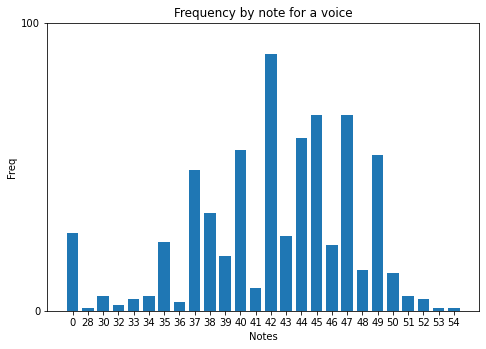

In [9]:
# frequency per note in the voice after transform
notes = []
freq = []
for x in set_X:
    notes.append(str(x))
    freq.append(X.count(x))
#     print(f"{x}:\t{X.count(x)}/{len(X)} ~\t{round((X.count(x)/len(X))*100,2)} %")

bar_chart(notes, freq, set_X)

In [10]:
y = []
for x in X:
    # Conversion to n dimensional one hot vector
    n = set_X.index(x)
    y.append([1 if i==n else 0 for i in range(len(set_X))])
y[0]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
# Sliding window with one-step forecasting
X_t0 = np.array(X[:-1]).reshape(-1, 1)
y_t1 = np.array(y[1:])
print(X_t0[:3])
print(y_t1[:2])

[[ 0]
 [42]
 [49]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


In [12]:
reg = LinearRegression().fit(X_t0, y_t1)

In [13]:
# Sanity check on last training instance
reg.predict([X_t0[-1]])[0]

array([0.03928345, 0.00135228, 0.0071157 , 0.00294549, 0.00583429,
       0.00708736, 0.0335176 , 0.00432611, 0.071222  , 0.04942137,
       0.02828686, 0.08244535, 0.0116544 , 0.13234272, 0.0390992 ,
       0.09139762, 0.10444095, 0.03628956, 0.1068503 , 0.02173806,
       0.08444612, 0.02079679, 0.00819282, 0.00658544, 0.0016499 ,
       0.00167825])

In [16]:
# Get the max probability 
# Trace back the note via its index e.g.
yhat = reg.predict([X_t0[49]])
pred = set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]
pred

42

In [17]:
d = {}
for i in set_X:
    x = [i]
    yhat = reg.predict([x])
    pred = set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]
    d[i] = pred
d

{0: 42,
 28: 42,
 30: 42,
 32: 42,
 33: 42,
 34: 42,
 35: 42,
 36: 42,
 37: 42,
 38: 42,
 39: 42,
 40: 42,
 41: 42,
 42: 42,
 43: 42,
 44: 42,
 45: 42,
 46: 47,
 47: 47,
 48: 47,
 49: 47,
 50: 47,
 51: 47,
 52: 47,
 53: 47,
 54: 47}

In [18]:
preds = [X_t0[-1]]
for i in range(5):
    yhat = reg.predict([preds[-1]])
    preds.append([set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]])
preds

[array([42]), [42], [42], [42], [42], [42]]

In [ ]:
# Cross validation for time series
tscv = TimeSeriesSplit()
print(tscv)

avg_acc = 0

for train_index, test_index in tscv.split(X_t0):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}] TEST: [{test_index[0]} ... {test_index[-1]}]")
    X_train, X_test = X_t0[train_index], X_t0[test_index]
    y_train, y_test = y_t1[train_index], y_t1[test_index]
    
    reg = LinearRegression().fit(X_train, y_train)
    yhat_vec = reg.predict(X_test)